## Preamble goes here

In [11]:
import sys
sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from toffy import detector_sweep, watcher_functions, normalize
from ark.utils.io_utils import list_files, list_folders

In [2]:
masses = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]

In [15]:
# top level directory containing run folders
bin_file_dir = '/Volumes/Noah/rosetta_testing/example_bins'

In [16]:
# directory to hold plots during testing
plot_dir = os.path.join(bin_file_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

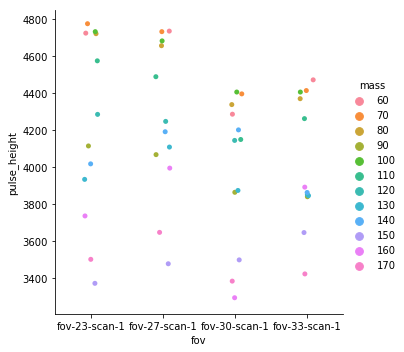

In [17]:
# To get a sense for the typical range of pulse heights, select a few runs immediately after a detector sweep, and a few runs immediately before a detector sweep
run_name = '20220222_test_run'
run_path = os.path.join(bin_file_dir, run_name)
bin_files = list_files(run_path, '.bin')
bin_files = [file.split('.bin')[0] for file in bin_files]
for file in bin_files:
    print("Computing MPH for {}".format(file))
    watcher_functions.write_mph_per_mass(base_dir=run_path, fov=file, masses=masses)
normalize.combine_run_metrics(run_path, 'pulse_heights')
count_data = pd.read_csv(os.path.join(run_path, 'pulse_heights_combined.csv'))
sns.catplot(x='fov', y='pulse_height', data=count_data, hue='mass')
plt.savefig(os.path.join(plot_dir, '{}_fov_vs_mph.jpg'.format(run_name)))

### Construct tuning curve
To normalize the image data, we need to determine the relationship between pulse height and total signal. Once we have found the relationship between these two features, we can use the pulse height of data from a run to determine how much the signal needs to be compensated. To do this, we'll use data from detector sweeps

In [68]:
# this line should only be run once, at the beginning of the entire process
final_included_fovs = []

In [80]:
# The cells below can be re-run for multiple different detector sweeps. 
sweep_sub_folder = 'sweep2'
sweep_start = 'Detector_2025v_2022-01-13_13-30-55'
sweep_end = 'Detector_2400v_2022-01-13_13-46-17'
sweep_dir = os.path.join(bin_file_dir, sweep_sub_folder)
sweep_fovs = detector_sweep.find_detector_sweep_folders(data_dir=sweep_dir, first_fov=sweep_start, last_fov=sweep_end)

sweep_fov_paths = [os.path.join(bin_file_dir, sweep_sub_folder, fov) for fov in sweep_fovs]

In [42]:
# compute pulse heights for each FOV if not already computed
for fov in sweep_fovs:
    if not os.path.exists(os.path.join(bin_file_dir, fov, 'fov-1-scan-1_pulse_heights.csv')):
        fov_path = os.path.join(bin_file_dir, sweep_sub_folder, fov)
        watcher_functions.write_mph_per_mass(base_dir=fov_path, fov='fov-1-scan-1', masses=masses)

/Users/noahgreenwald/anaconda3/envs/test_env_38/lib/python3.8/site-packages/mibi_bin_tools/bin_files.py:411: RuntimeWarning: invalid value encountered in true_divide
  int_bin = np.cumsum(intensities) / intensities.sum()


In [43]:
# compute channel counts for each FOV if not already computed
for fov in sweep_fovs:
    if not os.path.exists(os.path.join(bin_file_dir, fov, 'fov-1-scan-1_channel_counts.csv')):
        fov_path = os.path.join(bin_file_dir, sweep_sub_folder, fov)
        watcher_functions.write_counts_per_mass(base_dir=fov_path, fov='fov-1-scan-1', masses=masses)

In [81]:
# combine data together into single df
combined_norm_data = normalize.combine_tuning_curve_metrics(sweep_fov_paths)

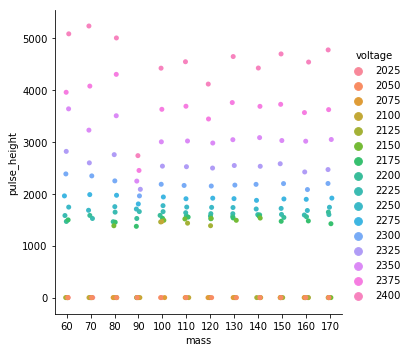

In [82]:
# plot the data to see what the distribution of pulse_heights looks like
import seaborn as sns
sns.catplot(x='mass', y='pulse_height', data=combined_norm_data, hue='voltage')

### Setting a minimum and maximum MPH range
In order to generate a more accurate fit, it's helpful to limit the range of MPH values. You want to set the min/max so that all of your actual data will have MPH values within the range, but outlier values from the detector sweep will not be included

In [87]:
mph_min = 1800
mph_max = 6000

reject_idx = np.logical_or(combined_norm_data['pulse_height'] < mph_min, combined_norm_data['pulse_height'] > mph_max)
remove_voltage = np.unique(combined_norm_data.loc[reject_idx,  'voltage'])
subset_df = combined_norm_data.loc[~np.isin(combined_norm_data['voltage'], remove_voltage), :]

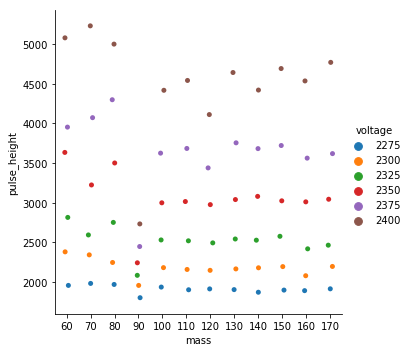

In [88]:
# plot the subsetted datatframe to make sure cutoffs are reasonable
sns.catplot(x='mass', y='pulse_height', data=subset_df, hue='voltage')

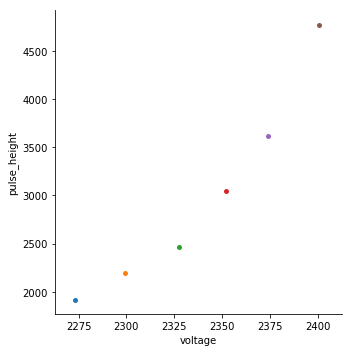

In [89]:
# pick a couple different masses to plot to ensure min/max values were selected appropriately
viz_mass = 170
plot_df = subset_df.loc[subset_df['mass'] == viz_mass, :]
sns.catplot(x='voltage', y='pulse_height', data=plot_df)

In [90]:
# update list of included FOVs
final_included_fovs.extend(np.unique(subset_df['directory'].values))

In [93]:
final_included_fovs1 = [fov for fov in final_included_fovs if 'sweep1' in fov]

In [94]:
final_included_fovs2 = [fov for fov in final_included_fovs if 'sweep2' in fov]

### Fit function

Once you have selected the appropriate FOVs from the detector sweeps, we'll use them to fit a function for predicting

In [101]:
# read in all data
fit_data = normalize.combine_tuning_curve_metrics(final_included_fovs)

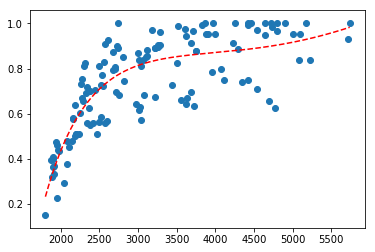

In [102]:
coeffs = normalize.fit_calibration_curve(fit_data['pulse_height'].values, fit_data['norm_channel_count'].values, 'exp', True)

In [ ]:
# TODO: once params have been picked, normalized data
extracted_tif_dir = 'path_to_extracted_tifs'
normalized_tif_dir = 'path_to_normalized_tifs'